In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.arima_model import ARIMA

import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y %H:%M:%S')
# df = pd.read_csv("Microsoft_Stock.csv", parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = pd.read_csv("Electric_Production.csv")

In [3]:
df.head()

,DATE,value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [4]:
for i in df.columns:
    print("The number of NaA in {} is {}".format(i, df[i].isnull().sum()))

The number of NaA in DATE is 0
The number of NaA in value is 0


In [5]:
# df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %H:%M:%S')

In [5]:
df.DATE = pd.to_datetime(df.DATE)

In [6]:
df.index = df.DATE

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.3 KB


In [8]:
df.shape

(397, 2)

In [9]:
df.head()

,DATE,value
DATE,,
1985-01-01,1985-01-01,72.5052
1985-02-01,1985-02-01,70.6720
1985-03-01,1985-03-01,62.4502
1985-04-01,1985-04-01,57.4714
1985-05-01,1985-05-01,55.3151


In [10]:
train = df.iloc[:-100]
test = df.iloc[-100:]

## Predict Elec

In [11]:
ts_train = train.value
ts_test = test.value

In [12]:
# check the stationary of data
ts_adf = ADF(ts_train.tolist())
ts_adf

(-2.0124011885142763,
 0.28116222119498974,
 15,
 281,
 {'1%': -3.4538376962008495,
  '5%': -2.8718811911083093,
  '10%': -2.5722803076202174},
 1301.256321127404)

In [13]:
ts_diff1 = ts_train.diff(1)
ts_diff1 = ts_diff1.fillna(0)
ts_adf_diff1 = ADF(ts_diff1.tolist())
ts_adf_diff1

(-6.066592764582827,
 1.1777665379276979e-07,
 14,
 282,
 {'1%': -3.4537536300652,
  '5%': -2.8718443180148836,
  '10%': -2.572260641818822},
 1303.6026899319318)

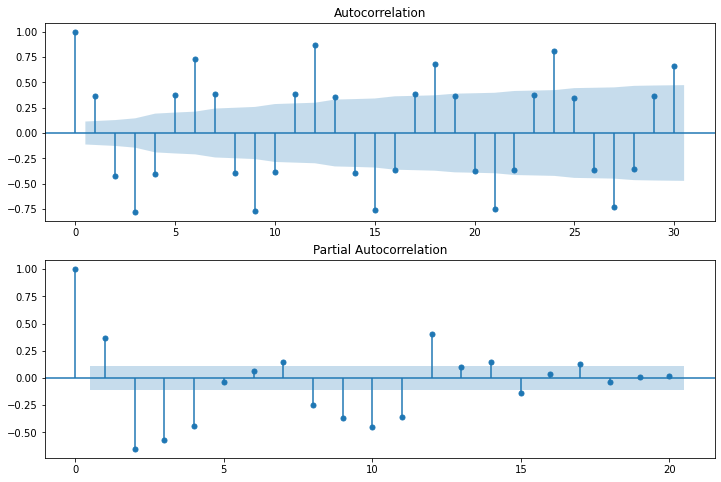

In [14]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211) 
sm.graphics.tsa.plot_acf(ts_diff1, lags=30, ax=ax1) 
ax2 = fig.add_subplot(212) 
sm.graphics.tsa.plot_pacf(ts_diff1, lags=20, ax=ax2) 
plt.show()

In [15]:
train_results = sm.tsa.arma_order_select_ic(ts_diff1, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 4)
BIC (3, 3)


In [16]:
## AR(p=2)
model = sm.tsa.ARIMA(ts_train, order=(3, 1, 3))
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59758D+00    |proj g|=  4.41360D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1      3      1     0     0   4.414D+05   2.598D+00
  F =   2.5975785199653010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


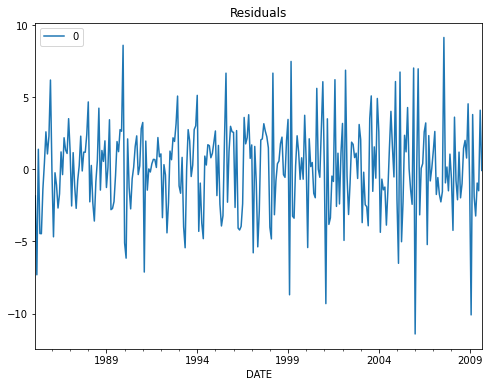

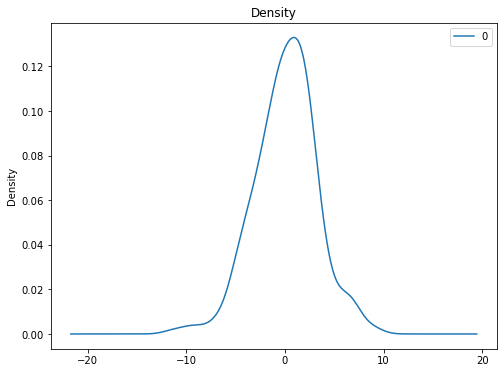

In [17]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
fig1, ax1 = plt.subplots(figsize=(8,6))
residuals.plot(title="Residuals", ax=ax1)
fig2, ax2 = plt.subplots(figsize=(8,6))
residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()

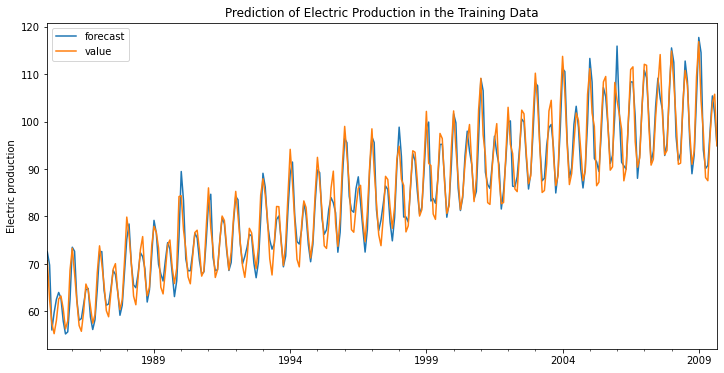

In [18]:
fig3, ax3 = plt.subplots(figsize=(12,6))
model_fit.plot_predict(dynamic=False, ax=ax3)
plt.ylabel("Electric production")
plt.title("Prediction of Electric Production in the Training Data")
plt.show()

In [19]:
ts_test

DATE
2009-10-01     89.2977
2009-11-01     89.3585
2009-12-01    110.6844
2010-01-01    119.0166
2010-02-01    110.5330
                ...   
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048
Name: value, Length: 100, dtype: float64

In [20]:
predict = model_fit.forecast(steps=100, alpha=0.05)[0]

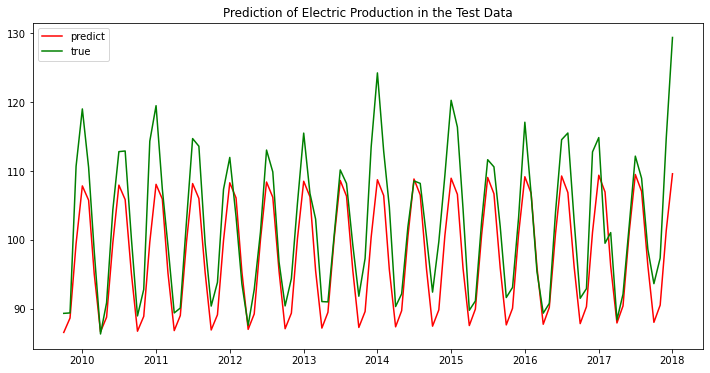

In [21]:
plt.figure(figsize=(12,6))
plt.plot(ts_test.index, predict, label='predict', color='red')
plt.plot(ts_test.index, ts_test.values, label='true', color='green')
plt.legend()
plt.title("Prediction of Electric Production in the Test Data")
plt.show()

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

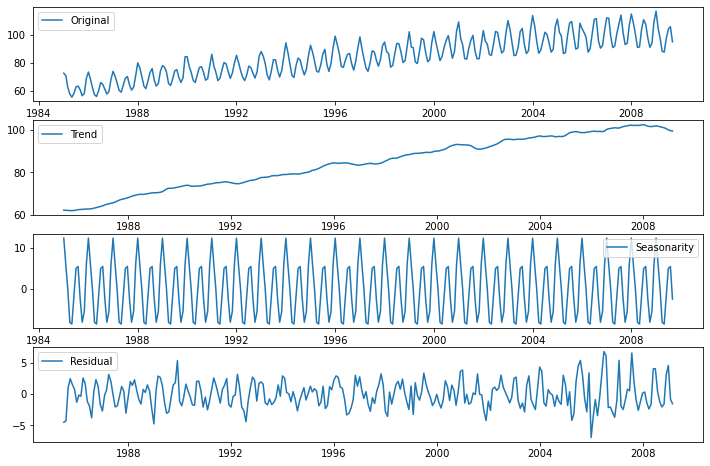

In [24]:
decomposition = seasonal_decompose(ts_train) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8)) 
plt.subplot(411)
plt.plot(ts_train, label='Original') 
plt.legend(loc='best') 
plt.subplot(412)
plt.plot(trend, label='Trend') 
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonarity') 
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual') 
plt.legend(loc='best')
plt.show()

In [25]:
trend2 = trend.dropna()

In [28]:
trend2

DATE
1985-07-01     62.199021
1985-08-01     62.120496
1985-09-01     61.999112
1985-10-01     61.971337
1985-11-01     61.973842
                 ...    
2008-11-01    100.909950
2008-12-01    100.475883
2009-01-01     99.910304
2009-02-01     99.548954
2009-03-01     99.355042
Name: trend, Length: 285, dtype: float64

In [26]:
# trend = trend.fillna(np.mean(trend))
# ADF(trend.tolist())

In [27]:
trend_diff1 = trend2.diff(1)
trend_diff1 = trend_diff1.fillna(0)
ADF(trend_diff1.tolist())

(-3.3134503621806406,
 0.014287844483228923,
 14,
 270,
 {'1%': -3.4548039258751206,
  '5%': -2.872304928618605,
  '10%': -2.5725063100137175},
 -416.81093168811503)

In [28]:
trend_diff2 = trend_diff1.diff(1)
trend_diff2 = trend_diff2.fillna(0)
ADF(trend_diff2.tolist())

(-7.300655237890968,
 1.3413782505954927e-10,
 15,
 269,
 {'1%': -3.4548957220044336,
  '5%': -2.8723451788613157,
  '10%': -2.572527778361272},
 -409.0986655841616)

In [29]:
residual = residual.fillna(0)
ADF(residual.tolist())

(-8.628372337296327,
 5.845911943305052e-14,
 14,
 282,
 {'1%': -3.4537536300652,
  '5%': -2.8718443180148836,
  '10%': -2.572260641818822},
 1087.6249391547658)

In [30]:
# seasonal = seasonal.fillna(0)
# ADF(seasonal.tolist())

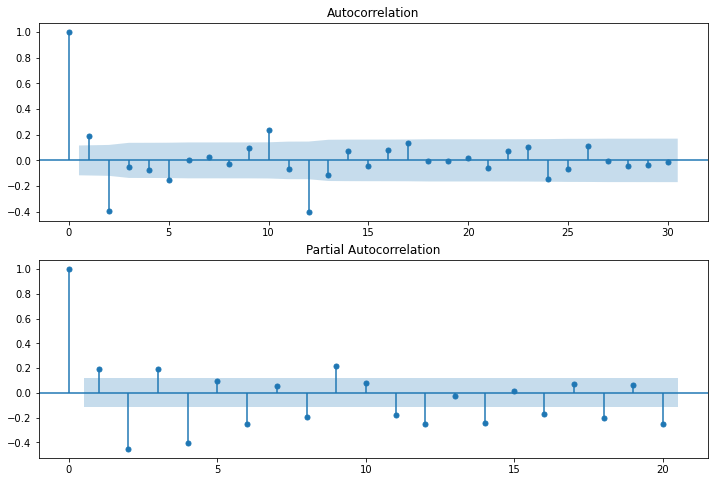

In [31]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211) 
sm.graphics.tsa.plot_acf(trend_diff2, lags=30, ax=ax1) 
ax2 = fig.add_subplot(212) 
sm.graphics.tsa.plot_pacf(trend_diff2, lags=20, ax=ax2) 
plt.show()

In [32]:
train_results = sm.tsa.arma_order_select_ic(trend_diff2, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 4)
BIC (4, 4)


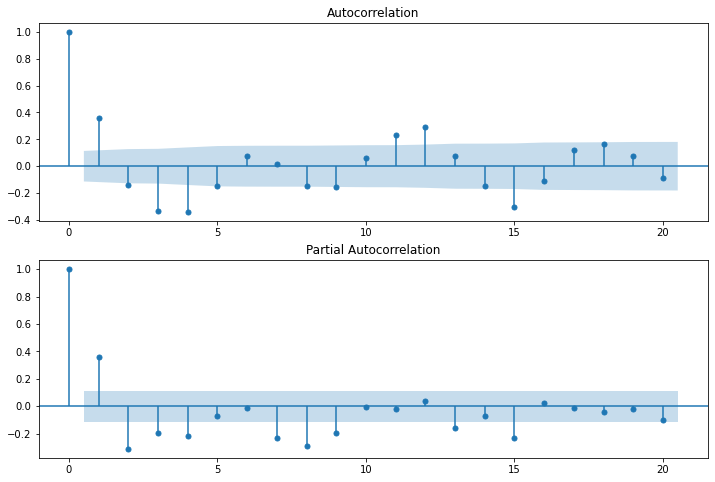

In [33]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211) 
sm.graphics.tsa.plot_acf(residual, lags=20, ax=ax1) 
ax2 = fig.add_subplot(212) 
sm.graphics.tsa.plot_pacf(residual, lags=20, ax=ax2) 
plt.show()

In [34]:
train_results = sm.tsa.arma_order_select_ic(residual, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 3)
BIC (2, 1)


In [35]:
sea_pred_seq = seasonal['2000-10-01':'2009-01-01']

In [36]:
sea_pred_seq.index = ts_test.index

In [37]:
def ARIMA_Model(timeseries, order):
    model = ARIMA(timeseries, order=order) 
    return model.fit()

In [38]:
trend_model = ARIMA_Model(trend2, (4, 2, 4)) 
trend_fit_seq = trend_model.fittedvalues
# trend_predict_seq2 = trend_model.predict(start='2009-10-01', end='2018-01-01', dynamic=True)
trend_predict_seq = trend_model.forecast(steps=106)[0]
trend_predict_seq = trend_predict_seq[6:]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.12968D-01    |proj g|=  7.05510D+00

At iterate    5    f= -8.14612D-01    |proj g|=  4.92823D-01

At iterate   10    f= -8.14739D-01    |proj g|=  8.61398D-03

At iterate   15    f= -8.14740D-01    |proj g|=  1.96239D-01

At iterate   20    f= -8.14858D-01    |proj g|=  1.67470D+00


 This problem is unconstrained.



At iterate   25    f= -8.15085D-01    |proj g|=  9.83114D-03

At iterate   30    f= -8.15089D-01    |proj g|=  7.90337D-02

At iterate   35    f= -8.15141D-01    |proj g|=  8.12162D-02

At iterate   40    f= -8.15149D-01    |proj g|=  7.97239D-02

At iterate   45    f= -8.15284D-01    |proj g|=  4.03954D-03

At iterate   50    f= -8.15287D-01    |proj g|=  2.40923D-01

At iterate   55    f= -8.15296D-01    |proj g|=  1.34137D-02

At iterate   60    f= -8.15296D-01    |proj g|=  2.46320D-03

At iterate   65    f= -8.15296D-01    |proj g|=  5.70684D-03

At iterate   70    f= -8.15296D-01    |proj g|=  3.56204D-04

At iterate   75    f= -8.15296D-01    |proj g|=  1.49304D-02

At iterate   80    f= -8.15302D-01    |proj g|=  1.63104D-01

At iterate   85    f= -8.15304D-01    |proj g|=  1.44564D-02

At iterate   90    f= -8.15304D-01    |proj g|=  1.83800D-02

At iterate   95    f= -8.15308D-01    |proj g|=  1.95949D-01

At iterate  100    f= -8.15323D-01    |proj g|=  5.79178D-02

At iter

In [39]:
residual_model = ARIMA_Model(residual, (2, 0, 1))
residual_fit_seq = residual_model.fittedvalues
# residual_predict_seq = residual_model.predict(start='2005-11-01', end='2018-01-01', dynamic=True)
residual_predict_seq = residual_model.forecast(steps=100)[0]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95172D+00    |proj g|=  5.30098D-02

At iterate    5    f=  1.95114D+00    |proj g|=  4.70515D-02

At iterate   10    f=  1.94942D+00    |proj g|=  1.58635D-01

At iterate   15    f=  1.94621D+00    |proj g|=  1.70015D-02

At iterate   20    f=  1.94402D+00    |proj g|=  1.67933D-01

At iterate   25    f=  1.94386D+00    |proj g|=  2.01246D-03

At iterate   30    f=  1.94385D+00    |proj g|=  9.99512D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [40]:
predict_seq = pd.Series(sea_pred_seq, index=sea_pred_seq.index) 
predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)

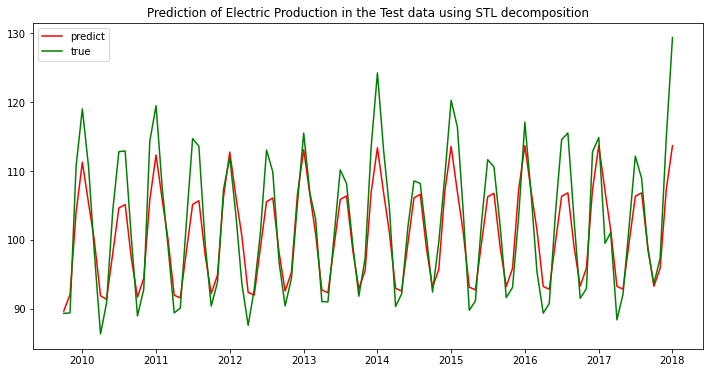

In [41]:
plt.figure(figsize=(12,6))
plt.plot(ts_test.index, predict_seq, label='predict', color='red')
plt.plot(ts_test.index, ts_test.values, label='true', color='green')
plt.legend()
plt.title("Prediction of Electric Production in the Test data using STL decomposition")
plt.show()

In [42]:
pd.DataFrame(predict_seq).to_csv("../output/Elec_arima.csv", index=False)